<a href="https://colab.research.google.com/github/GenaroHacker/creating_chord_collection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [552]:
%%capture
#@title Set Up
!git clone https://github.com/GenaroHacker/write_imports.git
from write_imports.write_imports import write_imports

!git clone https://github.com/GenaroHacker/creating_chord_collection.git


from creating_chord_collection.collection.resources.scales import scales
from creating_chord_collection.collection.resources.transposable_figures import transposable_figures



In [553]:



# Delete this line to see the new imports
%%capture



#@title Import Statements
#Modules: ['write_imports', 'creating_chord_collection']



from write_imports.write_imports import write_imports

from write_imports.LearningPython.BasicExamples.intro_functions import print_hello_world


from creating_chord_collection.collection.chord import GuitarChord

from creating_chord_collection.collection.collection import ChordCollection







print(write_imports([]))






In [554]:
# @title Chord


# Example
chord = GuitarChord('E', 'm', transposable_figures, finger_ascending=[0, 0, 0, 2, 2, 0], starting_fret=1)
print(chord)
print("String Frequencies:", chord.calculate_frequencies())
print("Is Open Chord:", chord.is_open())
chord.transpose(0)
print(chord.get_notes(include_strings=True))
print(chord.get_notes())

# Validate the chord against the C major scale
ionian_scale = scales["ionian"]
tonic = "C"
is_chord_in_scale = chord.validate_against_scale(tonic, ionian_scale)
print(f"Chord fits in C major scale: {is_chord_in_scale}")


('E', 'm', finger_ascending=[0, 0, 0, 2, 2, 0], starting_fret=1)
String Frequencies: {1: 329.63, 2: 246.94, 3: 196.0, 4: 164.81110255326524, 5: 123.47082531403103, 6: 82.41}
Is Open Chord: True
{1: 'E', 2: 'B', 3: 'G', 4: 'E', 5: 'B', 6: 'E'}
['E', 'B', 'G']
Chord fits in C major scale: True


In [555]:
# @title Scale
from creating_chord_collection.collection.resources.scales import scales

print(scales["ionian"])

[0, 2, 4, 5, 7, 9, 11]


In [556]:
# @title Abstract Builders
from PIL import Image, ImageDraw, ImageFont

class AbstractBuilder:
    all_notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    open_string_notes = ["E", "B", "G", "D", "A", "E"]

    def __init__(self):
        self.image_size = None
        self.fret_edges = []
        self.frets_starting_points = []
        self.string_edges = []
        self.strings_starting_points = []
        self.notes_coordenates = None
        self.name_coordenate = None
        self.font = "/content/creating_chord_collection/times.ttf"
        self.font_size = 50
        self.line_thickness = 3
        self.is_horizontal = None
        self.root = None
        self.starting_fret = None
        self.chord_type = None
        self.finger_ascending = None
        self.scale_name = None
        self.scale = None
        self.note_colors = {'C': (13, 116, 255), 'D': (255, 0, 6), 'E': (255, 242, 0), 'F': (152, 39, 201), 'G': (253, 148, 4), 'A': (32, 255, 49), 'B': (255, 77, 215)}


    def draw_boundaries(self):
        self.image = Image.new('RGB', self.image_size, 'white')
        self.draw = ImageDraw.Draw(self.image)

    def draw_frets(self):
        for fret_start in self.frets_starting_points:
            start_point = (fret_start, self.fret_edges[0]) if self.is_horizontal else (self.fret_edges[0], fret_start)
            end_point = (fret_start, self.fret_edges[1]) if self.is_horizontal else (self.fret_edges[1], fret_start)
            self.draw.line(start_point + end_point, fill='black', width=self.line_thickness)

    def write_name(self, name):
        try:
            font = ImageFont.truetype(self.font, self.font_size)
        except IOError:
            font = ImageFont.load_default()
        self.draw.text(self.name_coordenate, name, fill='black', font=font)

    def draw_notes(self, notes_style):
        raise NotImplementedError

    def get_result(self):
        return self.image



    def get_note_colors(self, note):
        if note in ['C', 'D', 'E', 'F', 'G', 'A', 'B']:
            return (self.note_colors[note], None)

        if '#' in note:
            note_index = self.all_notes.index(note)
            previous_note = self.all_notes[note_index - 1]
            next_note = self.all_notes[(note_index + 1) % len(self.all_notes)]
            return (self.note_colors[previous_note], self.note_colors[next_note])

        raise ValueError(f"Unrecognized note: {note}")


    def draw_note_at_coordenate(self, coordenate, color_a, color_b, rotation_angle=45, label=''):
        draw = ImageDraw.Draw(self.image)
        radius = 15
        upper_left = (coordenate[0] - radius, coordenate[1] - radius)
        lower_right = (coordenate[0] + radius, coordenate[1] + radius)

        # Draw the circle or pie chart
        if color_b is None:
            draw.ellipse([upper_left, lower_right], fill=color_a)
        else:
            start_angle = rotation_angle
            end_angle = start_angle + 180
            draw.pieslice([upper_left, lower_right], start=start_angle, end=end_angle, fill=color_a)
            draw.pieslice([upper_left, lower_right], start=end_angle, end=start_angle + 360, fill=color_b)

        # Draw the label
        if label:
            try:
                font = ImageFont.truetype(self.font, int(radius * 1.2))
            except IOError:
                font = ImageFont.load_default()

            text_bbox = draw.textbbox((0, 0), label, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            text_coordenate = (coordenate[0] - text_width / 2, coordenate[1] - text_height / 2 - 3)  # Shift 7 pixels up
            draw.text(text_coordenate, label, fill='black', font=font)

    def coordenate_to_note(self, coordenate):
        def calculate_note(string, fret):
            note_index = self.all_notes.index(self.open_string_notes[string])
            return self.all_notes[(note_index + fret) % len(self.all_notes)]

        def find_string_index(coord, coord_list):
            if coord in coord_list:
                return coord_list.index(coord)
            else:
                raise ValueError("Coordenate not found in diagram")

        if self.is_horizontal == False:
            string_coord, fret_coord = coordenate
            string_index = find_string_index(string_coord, self.notes_coordenates["strings"])
            fret_index = find_string_index(fret_coord, self.notes_coordenates["frets"])
        else:
            fret_coord, string_coord = coordenate
            fret_index = find_string_index(fret_coord, self.notes_coordenates["frets"])
            string_index = find_string_index(string_coord, self.notes_coordenates["strings"])
            fret_index += self.starting_fret - 1

        return calculate_note(string_index, fret_index)

    def get_chord_figure_coordenates(self):
        # Initialize an empty list to store coordenates
        chord_coordenates = []

        # Adjust fret numbers if the diagram is horizontal
        adjusted_finger_ascending = [
            fret + self.starting_fret - 1 if fret is not None else None
            for fret in self.finger_ascending
        ] if self.is_horizontal else self.finger_ascending

        # Iterate over the finger positions
        for string_index, fret in enumerate(adjusted_finger_ascending):
            if fret is not None:
                # Calculate the x and y coordenates
                if self.is_horizontal:
                    x_coord = self.notes_coordenates['frets'][fret]
                    y_coord = self.notes_coordenates['strings'][string_index]
                else:
                    y_coord = self.notes_coordenates['frets'][fret]
                    x_coord = self.notes_coordenates['strings'][string_index]

                # Append the coordenate to the list
                chord_coordenates.append((x_coord, y_coord))

        return chord_coordenates


    def calculate_scale_notes(self):
        # Calculate notes in the scale
        root_index = self.all_notes.index(self.root)
        scale_notes = [self.all_notes[(root_index + interval) % len(self.all_notes)] for interval in self.scale]
        return scale_notes

    def get_scale_figure_coordenates(self):
        scale_notes = self.calculate_scale_notes()
        scale_coordenates = []

        for string_index, open_note in enumerate(self.open_string_notes):
            for fret_index, fret in enumerate(self.notes_coordenates['frets']):
                # Calculate the note at this string and fret
                note_index = (self.all_notes.index(open_note) + fret_index) % len(self.all_notes)
                note = self.all_notes[note_index]

                # Check if the note is in the scale
                if note in scale_notes:
                    # Calculate the coordenate
                    if self.is_horizontal:
                        x_coord = fret
                        y_coord = self.notes_coordenates['strings'][string_index]
                    else:
                        y_coord = fret
                        x_coord = self.notes_coordenates['strings'][string_index]

                        # Adjust for starting fret if not horizontal
                        if self.starting_fret > 1 and fret_index == 0:
                            continue

                    # Append the coordenate to the list
                    scale_coordenates.append((x_coord, y_coord))

        return scale_coordenates


class ShortAbstractBuilder(AbstractBuilder):
    def __init__(self):
        super().__init__()
        self.image_size = (351, 351)
        self.is_horizontal = False
        self.fret_edges = [78, 273]
        self.frets_starting_points = [107, 157, 207, 257, 307]
        self.string_edges = [107, 307]
        self.strings_starting_points = [273, 234, 195, 156, 117, 78]
        self.notes_coordenates = {"strings": [273, 234, 195, 156, 117, 78], "frets": [82, 132, 182, 232, 282]}
        self.name_coordenate = (145, 10)

    def draw_strings(self):
        custom_grey = (210, 210, 210)

        for index, string_start in enumerate(self.strings_starting_points):
            color = custom_grey if self.finger_ascending and self.finger_ascending[index] is None else 'black'
            start_point = (string_start, self.string_edges[0])
            end_point = (string_start, self.string_edges[1])
            self.draw.line(start_point + end_point, fill=color, width=self.line_thickness - 1)

    def write_starting_fret(self):
        try:
            font = ImageFont.truetype(self.font, 35)
        except IOError:
            font = ImageFont.load_default()

        starting_fret_text = str(self.starting_fret)
        self.draw.text((30, 110), starting_fret_text, fill='black', font=font)


class LongAbstractBuilder(AbstractBuilder):
    def __init__(self):
        super().__init__()
        self.image_size = (717, 362)
        self.is_horizontal = True
        self.fret_edges = [82, 277]
        self.frets_starting_points = [67, 117, 167, 217, 267, 317, 367, 417, 467, 517, 567, 617, 667]
        self.string_edges = [67, 667]
        self.strings_starting_points = [82, 121, 160, 199, 238, 277]
        self.notes_coordenates = {"strings": [82, 121, 160, 199, 238, 277], "frets": [42, 92, 142, 192, 242, 292, 342, 392, 442, 492, 542, 592, 642]}
        self.name_coordenate = (330, 7)

    def draw_strings(self):
        for index, string_start in enumerate(self.strings_starting_points):
            start_point = (self.string_edges[0], string_start)
            end_point = (self.string_edges[1], string_start)
            self.draw.line(start_point + end_point, fill='black', width=self.line_thickness - 1)

    def write_starting_fret(self):
        try:
            font = ImageFont.truetype(self.font, 20)
        except IOError:
            font = ImageFont.load_default()

        for i, fret_start in enumerate(self.frets_starting_points, start=1):
            if i > 12:  # Only write numbers for frets 1 to 12
                break
            fret_number_text = str(i)
            x_coordenate = fret_start + 15
            y_coordenate = 300
            self.draw.text((x_coordenate, y_coordenate), fret_number_text, fill='black', font=font)




In [557]:
# @title Concrete Builders


class ShortChordBuilder(ShortAbstractBuilder):
    def __init__(self):
        super().__init__()
        self.is_scale = False

class ShortScaleBuilder(ShortAbstractBuilder):
    def __init__(self):
        super().__init__()
        self.is_scale = True

class LongChordBuilder(LongAbstractBuilder):
    def __init__(self):
        super().__init__()
        self.is_scale = False

class LongScaleBuilder(LongAbstractBuilder):
    def __init__(self):
        super().__init__()
        self.is_scale = True


In [558]:
class Director:
    def __init__(self, builder):
        self._builder = builder

    def _build_diagram(self, root, starting_fret, finger_ascending=None, scale=None):
        self._builder.draw_boundaries()
        self._builder.root = root
        self._builder.starting_fret = starting_fret
        self._builder.finger_ascending = finger_ascending
        self._builder.scale = scale
        self._builder.write_starting_fret()
        self._builder.draw_frets()
        self._builder.draw_strings()

        # Draw notes for a chord
        if finger_ascending is not None:
            chord_coords = self._builder.get_chord_figure_coordenates()
            for coord in chord_coords:
                note = self._builder.coordenate_to_note(coord)
                note_colors = self._builder.get_note_colors(note)
                self._builder.draw_note_at_coordenate(coord, *note_colors, label=note)

        # Draw notes for a scale
        if scale is not None:
            scale_coords = self._builder.get_scale_figure_coordenates()
            for coord in scale_coords:
                note = self._builder.coordenate_to_note(coord)
                note_colors = self._builder.get_note_colors(note)
                self._builder.draw_note_at_coordenate(coord, *note_colors, label=note)

    def build_chord(self, chord):
        self._build_diagram(chord.root, chord.starting_fret, finger_ascending=chord.finger_ascending)

    def build_scale(self, root, scale):
        self._build_diagram(root, starting_fret=1, scale=scale)


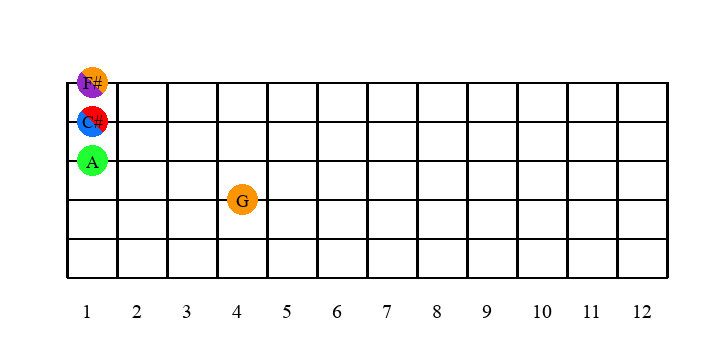

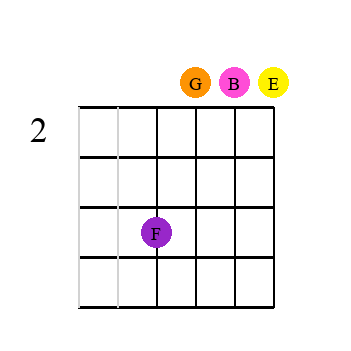

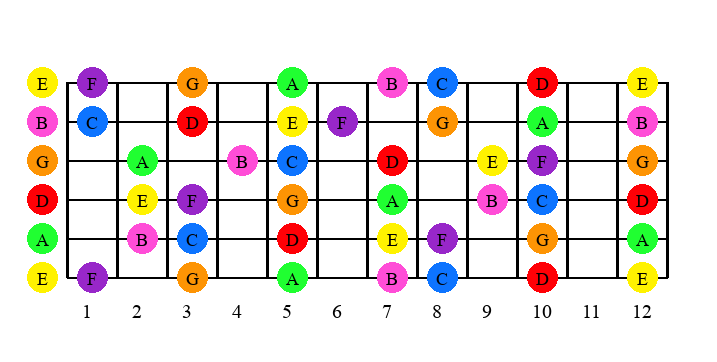

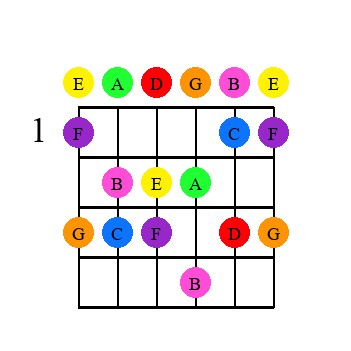

In [559]:
# Example usage for a chord
chord = GuitarChord('E', 'm', transposable_figures, finger_ascending=[0, 0, 0, 3, None, None], starting_fret=2)
builder = LongChordBuilder()
director = Director(builder)
director.build_chord(chord)

# Get the final image result and display it
result_image = builder.get_result()
display(result_image)

# Repeat the process with ShortChordBuilder
builder = ShortChordBuilder()
director = Director(builder)
director.build_chord(chord)

# Get the final image result and display it
result_image = builder.get_result()
display(result_image)

# Define the scale as a list of integers
ionian_scale = [0, 2, 4, 5, 7, 9, 11]
root_note = "C"

# Example usage for a scale with LongScaleBuilder
builder = LongScaleBuilder()
director = Director(builder)
director.build_scale(root_note, ionian_scale)

# Get the final image result and display it
result_image = builder.get_result()
display(result_image)

# Repeat the process with ShortScaleBuilder
builder = ShortScaleBuilder()
director = Director(builder)
director.build_scale(root_note, ionian_scale)

# Get the final image result and display it
result_image = builder.get_result()
display(result_image)
